In [16]:
#Load libraries
from sklearn.ensemble import AdaBoostClassifier
from sklearn import datasets
# Import train_test_split function
from sklearn.model_selection import train_test_split
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

In [17]:
# Load data
iris = datasets.load_iris()
X = iris.data
y = iris.target

In [18]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

In [19]:
# Create adaboost classifier object
abc = AdaBoostClassifier(n_estimators=50,learning_rate=1)
# Train Adaboost Classifier
model = abc.fit(X_train, y_train)
#Predict the response for test dataset
y_pred = model.predict(X_test)

In [27]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9555555555555556


In [33]:
!git clone https://github.com/eriklindernoren/ML-From-Scratch

fatal: destination path 'ML-From-Scratch' already exists and is not an empty directory.


In [29]:
import sys
sys.path.append('/content/ML-From-Scratch')

Accuracy: 0.9382022471910112


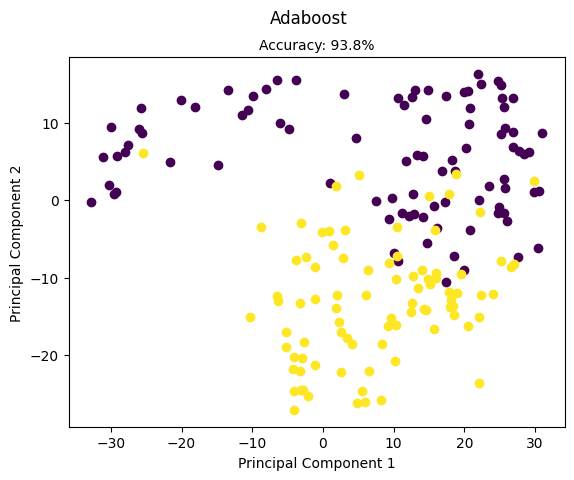

In [24]:
from __future__ import division, print_function
import numpy as np
import math
from sklearn import datasets
import matplotlib.pyplot as plt
import pandas as pd

# Import helper functions
from mlfromscratch.utils import train_test_split, accuracy_score, Plot

# Decision stump used as weak classifier in this impl. of Adaboost
class DecisionStump():
    def __init__(self):
        # Determines if sample shall be classified as -1 or 1 given threshold
        self.polarity = 1
        # The index of the feature used to make classification
        self.feature_index = None
        # The threshold value that the feature should be measured against
        self.threshold = None
        # Value indicative of the classifier's accuracy
        self.alpha = None

class Adaboost():
    """Boosting method that uses a number of weak classifiers in
    ensemble to make a strong classifier. This implementation uses decision
    stumps, which is a one level Decision Tree.

    Parameters:
    -----------
    n_clf: int
        The number of weak classifiers that will be used.
    """
    def __init__(self, n_clf=5):
        self.n_clf = n_clf

    def fit(self, X, y):
        n_samples, n_features = np.shape(X)

        # Initialize weights to 1/N
        w = np.full(n_samples, (1 / n_samples))

        self.clfs = []
        # Iterate through classifiers
        for _ in range(self.n_clf):
            clf = DecisionStump()
            # Minimum error given for using a certain feature value threshold
            # for predicting sample label
            min_error = float('inf')
            # Iterate throught every unique feature value and see what value
            # makes the best threshold for predicting y
            for feature_i in range(n_features):
                feature_values = np.expand_dims(X[:, feature_i], axis=1)
                unique_values = np.unique(feature_values)
                # Try every unique feature value as threshold
                for threshold in unique_values:
                    p = 1
                    # Set all predictions to '1' initially
                    prediction = np.ones(np.shape(y))
                    # Label the samples whose values are below threshold as '-1'
                    prediction[X[:, feature_i] < threshold] = -1
                    # Error = sum of weights of misclassified samples
                    error = sum(w[y != prediction])

                    # If the error is over 50% we flip the polarity so that samples that
                    # were classified as 0 are classified as 1, and vice versa
                    # E.g error = 0.8 => (1 - error) = 0.2
                    if error > 0.5:
                        error = 1 - error
                        p = -1

                    # If this threshold resulted in the smallest error we save the
                    # configuration
                    if error < min_error:
                        clf.polarity = p
                        clf.threshold = threshold
                        clf.feature_index = feature_i
                        min_error = error
            # Calculate the alpha which is used to update the sample weights,
            # Alpha is also an approximation of this classifier's proficiency
            clf.alpha = 0.5 * math.log((1.0 - min_error) / (min_error + 1e-10))
            # Set all predictions to '1' initially
            predictions = np.ones(np.shape(y))
            # The indexes where the sample values are below threshold
            negative_idx = (clf.polarity * X[:, clf.feature_index] < clf.polarity * clf.threshold)
            # Label those as '-1'
            predictions[negative_idx] = -1
            # Calculate new weights
            # Missclassified samples gets larger weights and correctly classified samples smaller
            w *= np.exp(-clf.alpha * y * predictions)
            # Normalize to one
            w /= np.sum(w)

            # Save classifier
            self.clfs.append(clf)

    def predict(self, X):
        n_samples = np.shape(X)[0]
        y_pred = np.zeros((n_samples, 1))
        # For each classifier => label the samples
        for clf in self.clfs:
            # Set all predictions to '1' initially
            predictions = np.ones(np.shape(y_pred))
            # The indexes where the sample values are below threshold
            negative_idx = (clf.polarity * X[:, clf.feature_index] < clf.polarity * clf.threshold)
            # Label those as '-1'
            predictions[negative_idx] = -1
            # Add predictions weighted by the classifiers alpha
            # (alpha indicative of classifier's proficiency)
            y_pred += clf.alpha * predictions

        # Return sign of prediction sum
        y_pred = np.sign(y_pred).flatten()

        return y_pred


def main():
    data = datasets.load_digits()
    X = data.data
    y = data.target

    digit1 = 1
    digit2 = 8
    idx = np.append(np.where(y == digit1)[0], np.where(y == digit2)[0])
    y = data.target[idx]
    # Change labels to {-1, 1}
    y[y == digit1] = -1
    y[y == digit2] = 1
    X = data.data[idx]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

    # Adaboost classification with 5 weak classifiers
    clf = Adaboost(n_clf=5)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print ("Accuracy:", accuracy)

    # Reduce dimensions to 2d using pca and plot the results
    Plot().plot_in_2d(X_test, y_pred, title="Adaboost", accuracy=accuracy)


if __name__ == "__main__":
    main()